In [2]:
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd
import time

seasons = ['2021-22', '2022-23']  # Add more if desired
all_shots = []

for season in seasons:
    print(f"Fetching season {season}...")
    shots = shotchartdetail.ShotChartDetail(
    team_id=0,
    player_id=0,
    season_type_all_star='Regular Season',
    season_nullable='2021-22',
    context_measure_simple='FGA',
    timeout=120  # increase from 30s to 120s
    )
    df = shots.get_data_frames()[0]
    df['SEASON'] = season
    all_shots.append(df)
    time.sleep(1)  # polite delay for API
    
shot_df = pd.concat(all_shots, ignore_index=True)
shot_df.to_csv("nba_shots_multi_season.csv", index=False)
print("All seasons saved to nba_shots_multi_season.csv")


Fetching season 2021-22...
Fetching season 2022-23...
All seasons saved to nba_shots_multi_season.csv


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Features: location + shot type + optional period/shot clock
# Only fill missing if column exists
if 'SHOT_CLOCK' in shot_df.columns:
    shot_df['SHOT_CLOCK'] = shot_df['SHOT_CLOCK'].fillna(24)
else:
    shot_df['SHOT_CLOCK'] = 24  # default to 24 if missing

features = ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'ACTION_TYPE', 'PERIOD']

# Only include SHOT_CLOCK if it exists
if 'SHOT_CLOCK' in shot_df.columns:
    features.append('SHOT_CLOCK')

X = shot_df[features]
y = shot_df['SHOT_MADE_FLAG']

# One-hot encode ACTION_TYPE
preprocessor = ColumnTransformer([
    ('action_type', OneHotEncoder(handle_unknown='ignore'), ['ACTION_TYPE'])
], remainder='passthrough')

X_processed = preprocessor.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicted probability of make (xShot)
shot_df['xShot'] = model.predict_proba(X_processed)[:, 1]


c:\Users\34dan\OneDrive\Desktop\NBA-Viz\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 2 or 3 points depending on shot type
shot_df['SHOT_VALUE'] = shot_df['SHOT_TYPE'].apply(lambda x: 3 if '3PT' in x else 2)
shot_df['xPoints'] = shot_df['xShot'] * shot_df['SHOT_VALUE']


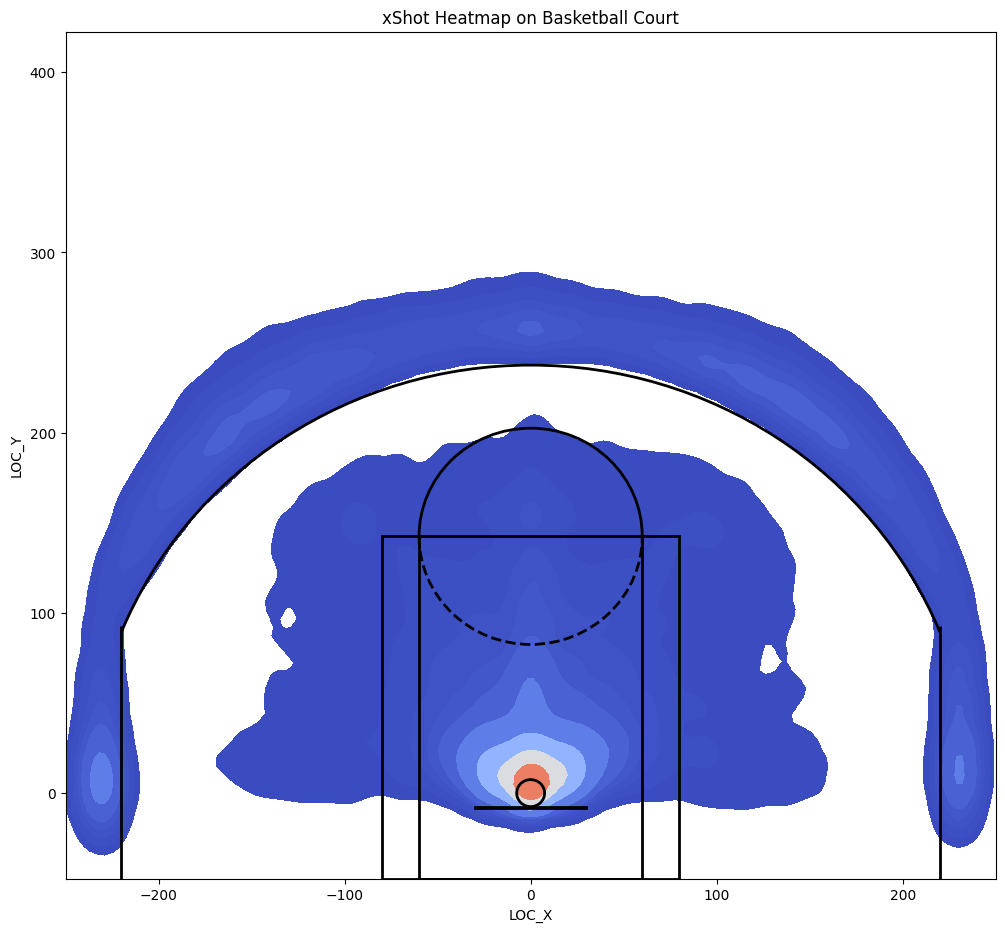

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    # Hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Free throw circle
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')

    # 3-point line
    corner_left = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_right = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                      corner_left, corner_right, three_arc]

    if outer_lines:
        # Add outer lines for full court if needed
        outer_lines_rect = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines_rect)

    for element in court_elements:
        ax.add_patch(element)

    return ax

# Plot heatmap
plt.figure(figsize=(12,11))
sns.kdeplot(
    x=shot_df['LOC_X'], 
    y=shot_df['LOC_Y'], 
    weights=shot_df['xShot'], 
    fill=True, 
    cmap='coolwarm', 
    bw_adjust=0.5
)

# Draw court on top
draw_court()
plt.xlim(-250, 250)
plt.ylim(-47.5, 422.5)
plt.title("xShot Heatmap on Basketball Court")
plt.show()



In [13]:
# Shooter-level
import pandas as pd

# Aggregate shooter stats
shooter_stats = shot_df.groupby('PLAYER_NAME').agg(
    xShot_total=('xShot','sum'),
    xPoints_total=('xPoints','sum')
).sort_values('xPoints_total', ascending=False)

# Save basic shooter stats
shooter_stats.to_csv("shooter_xShot_xPoints.csv")

# Compute rough actual points (2 points per made shot, adjust if you want 3s too)
actual_points = shot_df.groupby('PLAYER_NAME')['SHOT_MADE_FLAG'].sum() * 2

# Merge expected and actual points
comparison = shooter_stats.merge(
    actual_points.rename('actual_points'),
    left_index=True,
    right_index=True
)

# Difference between expected points and actual points
comparison['diff'] = comparison['xPoints_total'] - comparison['actual_points']

# Save comparison table
comparison.to_csv("shooter_xPoints_comparison.csv")

# Preview top 10
print(comparison.head(10))



                       xShot_total  xPoints_total  actual_points        diff
PLAYER_NAME                                                                 
Jayson Tatum           1391.007375    3228.351038           2832  396.351038
Trae Young             1268.117475    2933.910343           2844   89.910343
DeMar DeRozan          1382.166074    2863.509704           3096 -232.490296
Giannis Antetokounmpo  1332.813425    2827.168050           2756   71.168050
Devin Booker           1230.918347    2792.402638           2648  144.402638
Donovan Mitchell       1146.892505    2733.919254           2468  265.919254
Nikola Jokić           1270.752000    2733.287593           3056 -322.712407
Luka Dončić            1174.135104    2728.761444           2564  164.761444
Joel Embiid            1264.506123    2698.885381           2664   34.885381
Miles Bridges          1183.199160    2688.506073           2384  304.506073
